In [1]:
# import os
# os.environ["KERAS_BACKEND"] = "torch"

In [1]:
import pandas as pd
from geographiclib.geodesic import Geodesic
from sklearn.preprocessing import OneHotEncoder
from data_cleaner import DataCleaner

import keras_core
from keras_core.models import Sequential
from keras_core.layers import Dense
from keras_core.utils import to_categorical
from keras_core.regularizers import l2
from keras_core.callbacks import EarlyStopping

from imblearn.combine import SMOTETomek

import matplotlib.pyplot as plt

Using TensorFlow backend


In [2]:
df = pd.read_csv("input/merged.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Time'],
      dtype='object')

In [4]:
df = df[['Date', 'Species', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel']]

In [5]:
df.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,65.0,0,9,421,1917,0.0,5.8,18,29.39,30.11
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,65.0,0,9,421,1917,0.0,5.8,18,29.39,30.11
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,65.0,0,9,421,1917,0.0,5.8,18,29.39,30.11
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,65.0,0,9,421,1917,0.0,5.8,18,29.39,30.11
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,65.0,0,9,421,1917,0.0,5.8,18,29.39,30.11


In [6]:
len(df.columns)

20

In [7]:
df["latlon"] = df["Latitude"] + df["Longitude"]
df.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,...,Heat,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel,latlon
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,-45.846301
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,-45.846301
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,-45.774288
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,-45.850723
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,-45.850723


In [8]:
df["Latitude"].nunique()

138

In [9]:
df["Longitude"].nunique()

138

In [10]:
df["latlon"].nunique()

138

In [11]:
df["latlon"].unique()

array([-45.846301, -45.774288, -45.850723, -45.744855, -45.763373,
       -45.787116, -45.75895 , -45.774916, -45.71012 , -45.988385,
       -45.786568, -45.945166, -45.94559 , -45.720434, -45.796456,
       -45.670339, -45.853241, -45.916658, -45.830863, -45.887894,
       -45.799905, -45.748627, -45.771695, -45.702857, -45.961918,
       -45.794793, -45.926775, -45.798824, -45.758345, -46.062594,
       -45.798327, -45.823725, -45.751684, -45.744304, -45.768023,
       -45.673267, -45.669061, -45.88425 , -45.870202, -45.833624,
       -46.025386, -45.888741, -45.782531, -45.727834, -45.780269,
       -45.793397, -45.806843, -45.769607, -45.755684, -45.842952,
       -45.874003, -45.867235, -45.837589, -45.828127, -45.81063 ,
       -45.92659 , -45.827186, -45.956029, -45.70769 , -45.86155 ,
       -45.817744, -45.651728, -45.817558, -45.90631 , -45.854736,
       -45.785265, -45.834271, -45.816573, -45.821801, -45.9994  ,
       -45.785639, -45.841093, -45.892299, -45.814913, -45.855

In [12]:
latlon_dict = {}

for n in range(len(df["latlon"].unique())):
    latlon_dict[df["latlon"].unique()[n]] = (n + 1)

In [13]:
latlon_dict

{-45.846301: 1,
 -45.774288: 2,
 -45.850722999999995: 3,
 -45.744855: 4,
 -45.763372999999994: 5,
 -45.787116: 6,
 -45.75895: 7,
 -45.774916000000005: 8,
 -45.71012: 9,
 -45.988385: 10,
 -45.786568: 11,
 -45.94516600000001: 12,
 -45.945589999999996: 13,
 -45.720434: 14,
 -45.796456: 15,
 -45.670339000000006: 16,
 -45.853241: 17,
 -45.916658: 18,
 -45.830863: 19,
 -45.887894: 20,
 -45.799904999999995: 21,
 -45.748627000000006: 22,
 -45.77169500000001: 23,
 -45.702857: 24,
 -45.961918000000004: 25,
 -45.794793: 26,
 -45.926775: 27,
 -45.798823999999996: 28,
 -45.758345: 29,
 -46.062594000000004: 30,
 -45.798327: 31,
 -45.823725: 32,
 -45.751684: 33,
 -45.74430399999999: 34,
 -45.76802300000001: 35,
 -45.673267: 36,
 -45.66906099999999: 37,
 -45.88425: 38,
 -45.870202000000006: 39,
 -45.833624: 40,
 -46.025386: 41,
 -45.888741: 42,
 -45.782531000000006: 43,
 -45.727834: 44,
 -45.780269000000004: 45,
 -45.793397: 46,
 -45.806843: 47,
 -45.76960700000001: 48,
 -45.755684: 49,
 -45.842952: 5

In [14]:
df["gps_cat"] = df['latlon'].map(latlon_dict)
df.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,...,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel,latlon,gps_cat
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,-45.846301,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,-45.846301,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,-45.774288,2
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,-45.850723,3
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,-45.850723,3


In [15]:
df = df.drop(columns="latlon")

In [16]:
df.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,...,Heat,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel,gps_cat
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,2
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,3
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,3


In [17]:
df_spray = pd.read_csv("input/spray.csv")

In [18]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [19]:
df.dtypes

Date             object
Species          object
Latitude        float64
Longitude       float64
NumMosquitos      int64
WnvPresent        int64
Tmax              int64
Tmin              int64
Tavg            float64
DewPoint          int64
WetBulb         float64
Heat              int64
Cool              int64
Sunrise           int64
Sunset            int64
PrecipTotal     float64
ResultSpeed     float64
ResultDir         int64
StnPressure     float64
SeaLevel        float64
gps_cat           int64
dtype: object

In [20]:
df_spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [21]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date            datetime64[ns]
Species                 object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
Tmax                     int64
Tmin                     int64
Tavg                   float64
DewPoint                 int64
WetBulb                float64
Heat                     int64
Cool                     int64
Sunrise                  int64
Sunset                   int64
PrecipTotal            float64
ResultSpeed            float64
ResultDir                int64
StnPressure            float64
SeaLevel               float64
gps_cat                  int64
dtype: object

In [22]:
df_spray['Date'] = pd.to_datetime(df_spray['Date'])
df_spray.dtypes

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object

In [23]:
df.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,...,Heat,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel,gps_cat
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,2
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,3
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,3


In [24]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [25]:
td = pd.Timedelta(1, "d")
td2 = pd.Timedelta(2, "d")
td3 = pd.Timedelta(3, "d")
spray_list = []


for index, row in df.iterrows():
    lat1 = row["Latitude"]
    lon1 = row["Longitude"]

    sprayed = False

    for spr_index, spr_row in df_spray.iterrows():
        if row["Date"] - td == spr_row["Date"] or row["Date"] - td2 == spr_row["Date"] or row["Date"] - td3 == spr_row["Date"]:
            lat2 = spr_row["Latitude"]
            lon2 = spr_row["Longitude"]
            geo_dict = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)
            if geo_dict["s12"] <= 1000:
                sprayed = True
    
    if sprayed == True:
        spray_list.append(1)
    else:
        spray_list.append(0)

    print(index)

spr_ser = pd.Series(spray_list)
df["sprayed"] = spr_ser
df.head()      
    

In [26]:
df.to_csv('train_added_cols_1000m.csv', index=False)

In [27]:
df["sprayed"].value_counts()

KeyError: 'sprayed'

In [ ]:
df.dtypes

Date            datetime64[ns]
Species                 object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
Tmax                     int64
Tmin                     int64
Tavg                   float64
DewPoint                 int64
WetBulb                float64
Heat                     int64
Cool                     int64
Sunrise                  int64
Sunset                   int64
PrecipTotal            float64
ResultSpeed            float64
ResultDir                int64
StnPressure            float64
SeaLevel               float64
gps_cat                  int64
sprayed                  int64
dtype: object

In [ ]:
df.columns

Index(['Date', 'Species', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'Sunrise', 'Sunset', 'PrecipTotal', 'ResultSpeed', 'ResultDir',
       'StnPressure', 'SeaLevel', 'gps_cat', 'sprayed'],
      dtype='object')

In [ ]:
df.isnull().sum()

Date               0
Species            0
Latitude           0
Longitude          0
NumMosquitos       0
WnvPresent         0
Tmax               0
Tmin               0
Tavg               0
DewPoint           0
WetBulb           93
Heat               0
Cool               0
Sunrise            0
Sunset             0
PrecipTotal     1176
ResultSpeed        0
ResultDir          0
StnPressure       93
SeaLevel           0
gps_cat            0
sprayed            0
dtype: int64

In [ ]:
df["WnvPresent"].value_counts()

# use SMOTE to balance the classes

WnvPresent
0    9955
1     551
Name: count, dtype: int64

In [ ]:
score_dict = {
    "0":{
        "test_roc": 0.8613766280442932,
        "train_roc": 0.8521676549618751,
        "best_features": ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'sprayed', 'month'],
        "feature_len": 16},
    "1":{
        "test_roc": 0.8615627513734617,
        "train_roc": 0.8521692669499077,
        "best_features": ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'sprayed', 'month'],
        "feature_len": 15},
    "2":{
        "test_roc": 0.8616119563915179,
        "train_roc": 0.8526166669011376,
        "best_features": ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month'],
        "feature_len": 14},
    "3":{
        "test_roc": 0.8612332916873471,
        "train_roc": 0.8523562575616892,
        "best_features": ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'WetBulb', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month'],
        "feature_len": 13},
    "4":{
        "test_roc": 0.8612525458248472,
        "train_roc": 0.852293683117151,
        "best_features": ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month'],
        "feature_len": 12},
    "5":{
        "test_roc": 0.8613231443290146,
        "train_roc": 0.8522473750973054,
        "best_features": ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month'],
        "feature_len": 11},
    "6":{
        "test_roc": 0.8598748053192764,
        "train_roc": 0.8503012659088565,
        "best_features": ['NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month'],
        "feature_len": 10},
    "7":{
        "test_roc": 0.8595945506512177,
        "train_roc": 0.8446008365924802,
        "best_features": ['NumMosquitos', 'Tmin', 'Tavg', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month'],
        "feature_len": 9},
    "8":{
        "test_roc": 0.8573546526553595,
        "train_roc": 0.8434744965907919,
        "best_features": ['NumMosquitos', 'Tmin', 'Tavg', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'month'],
        "feature_len": 8},    
    "9":{
        "test_roc": 0.8573632100498041,
        "train_roc": 0.8437897135233485,
        "best_features": ['NumMosquitos', 'Tmin', 'Tavg', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'month'],
        "feature_len": 7}, 
    "10":{
        "test_roc": 0.856154478084513,
        "train_roc": 0.8442123474766232,
        "best_features": ['NumMosquitos', 'Tmin', 'Tavg', 'PrecipTotal', 'ResultDir', 'month'],
        "feature_len": 6}, 
    "11":{
        "test_roc": 0.8531037669650345,
        "train_roc": 0.8440891036643126,
        "best_features": ['NumMosquitos', 'Tavg', 'PrecipTotal', 'ResultDir', 'month'],
        "feature_len": 5}, 
    "12":{
        "test_roc": 0.8523892245289155,
        "train_roc": 0.8442016497378614,
        "best_features": ['NumMosquitos', 'PrecipTotal', 'ResultDir', 'month'],
        "feature_len": 4},
    "13":{
        "test_roc": 0.8525026100053056,
        "train_roc": 0.8436332041398198,
        "best_features": ['NumMosquitos', 'ResultDir', 'month'],
        "feature_len": 3},
    "14":{
        "test_roc": 0.8440564616885451,
        "train_roc": 0.820396982827345,
        "best_features": ['NumMosquitos', 'month'],
        "feature_len": 2},
    "15":{
        "test_roc": 0.7817992777559089,
        "train_roc": 0.7571510720013506,
        "best_features": ['NumMosquitos'],
        "feature_len": 1},                 
        }


In [ ]:
import json

with open("scores.json", "w") as file:
    json.dump(score_dict, file)

In [2]:
df = pd.read_csv("train_added_cols_1000m.csv")

In [3]:
df

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,...,Heat,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel,gps_cat
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,2
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,3
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,...,0,9,421,1917,0.0,5.8,18,29.39,30.11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,41.763733,-87.742302,6,1,75,50,63.0,52,...,2,0,543,1742,0.0,3.8,8,29.34,30.04,130
10502,2013-09-26,CULEX PIPIENS/RESTUANS,41.987280,-87.666066,5,0,75,50,63.0,52,...,2,0,543,1742,0.0,3.8,8,29.34,30.04,131
10503,2013-09-26,CULEX PIPIENS/RESTUANS,41.912563,-87.668055,1,0,75,50,63.0,52,...,2,0,543,1742,0.0,3.8,8,29.34,30.04,129
10504,2013-09-26,CULEX PIPIENS/RESTUANS,42.009876,-87.807277,5,0,75,50,63.0,52,...,2,0,543,1742,0.0,3.8,8,29.34,30.04,133


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date            datetime64[ns]
Species                 object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
Tmax                     int64
Tmin                     int64
Tavg                   float64
DewPoint                 int64
WetBulb                float64
Heat                     int64
Cool                     int64
Sunrise                  int64
Sunset                   int64
PrecipTotal            float64
ResultSpeed            float64
ResultDir                int64
StnPressure            float64
SeaLevel               float64
gps_cat                  int64
dtype: object

In [5]:
df["month"] = df["Date"].dt.month

In [6]:
df

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,DewPoint,...,Cool,Sunrise,Sunset,PrecipTotal,ResultSpeed,ResultDir,StnPressure,SeaLevel,gps_cat,month
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,1,5
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,1,5
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,2,5
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,3,5
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,88,60,74.0,58,...,9,421,1917,0.0,5.8,18,29.39,30.11,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,41.763733,-87.742302,6,1,75,50,63.0,52,...,0,543,1742,0.0,3.8,8,29.34,30.04,130,9
10502,2013-09-26,CULEX PIPIENS/RESTUANS,41.987280,-87.666066,5,0,75,50,63.0,52,...,0,543,1742,0.0,3.8,8,29.34,30.04,131,9
10503,2013-09-26,CULEX PIPIENS/RESTUANS,41.912563,-87.668055,1,0,75,50,63.0,52,...,0,543,1742,0.0,3.8,8,29.34,30.04,129,9
10504,2013-09-26,CULEX PIPIENS/RESTUANS,42.009876,-87.807277,5,0,75,50,63.0,52,...,0,543,1742,0.0,3.8,8,29.34,30.04,133,9


In [7]:
df.to_csv('train_sprayed_month_engineered.csv', index=False)

In [8]:
features = ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month']

cleaned = DataCleaner(df, features)

cleaned.clean()

In [9]:
n_input = cleaned.X_train.shape[1]

In [10]:
smt = SMOTETomek(random_state=42)

X_res, y_res = smt.fit_resample(cleaned.X_train, cleaned.y_train)

In [11]:
model = Sequential()
model.add(Dense(n_input, activation='relu', kernel_regularizer=l2(0.003)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [12]:
opt = keras_core.optimizers.Adam(learning_rate=0.00008)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[keras_core.metrics.AUC()]) 

es = EarlyStopping(patience=40)

In [13]:
history = model.fit(
    X_res,
    y_res,
    validation_data=(cleaned.X_test, cleaned.y_test),
    epochs=1000,
    batch_size=1000,
    verbose=2,
    callbacks = [es]
)

Epoch 1/1000
16/16 - 3s - 173ms/step - auc: 0.4763 - loss: 1.0284 - val_auc: 0.5375 - val_loss: 1.0856
Epoch 2/1000
16/16 - 0s - 8ms/step - auc: 0.6066 - loss: 1.0101 - val_auc: 0.6710 - val_loss: 1.0499
Epoch 3/1000
16/16 - 0s - 8ms/step - auc: 0.7110 - loss: 0.9937 - val_auc: 0.7568 - val_loss: 1.0226
Epoch 4/1000
16/16 - 0s - 8ms/step - auc: 0.7657 - loss: 0.9785 - val_auc: 0.7928 - val_loss: 1.0010
Epoch 5/1000
16/16 - 0s - 8ms/step - auc: 0.7910 - loss: 0.9627 - val_auc: 0.8095 - val_loss: 0.9811
Epoch 6/1000
16/16 - 0s - 8ms/step - auc: 0.8027 - loss: 0.9473 - val_auc: 0.8167 - val_loss: 0.9629
Epoch 7/1000
16/16 - 0s - 8ms/step - auc: 0.8098 - loss: 0.9315 - val_auc: 0.8203 - val_loss: 0.9446
Epoch 8/1000
16/16 - 0s - 8ms/step - auc: 0.8141 - loss: 0.9158 - val_auc: 0.8225 - val_loss: 0.9257
Epoch 9/1000
16/16 - 0s - 7ms/step - auc: 0.8178 - loss: 0.9004 - val_auc: 0.8246 - val_loss: 0.9044
Epoch 10/1000
16/16 - 0s - 8ms/step - auc: 0.8218 - loss: 0.8840 - val_auc: 0.8260 - val_

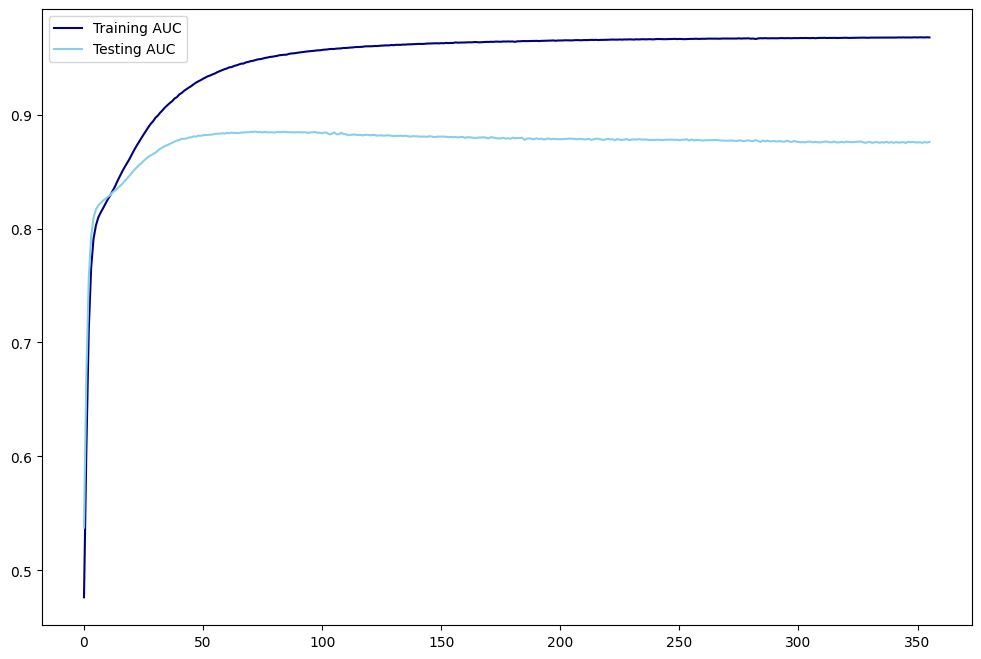

In [14]:
train_auc = history.history['auc']
test_auc = history.history['val_auc']

plt.figure(figsize=(12, 8))
plt.plot(train_auc, label='Training AUC', color='navy')
plt.plot(test_auc, label='Testing AUC', color='skyblue')
plt.legend();

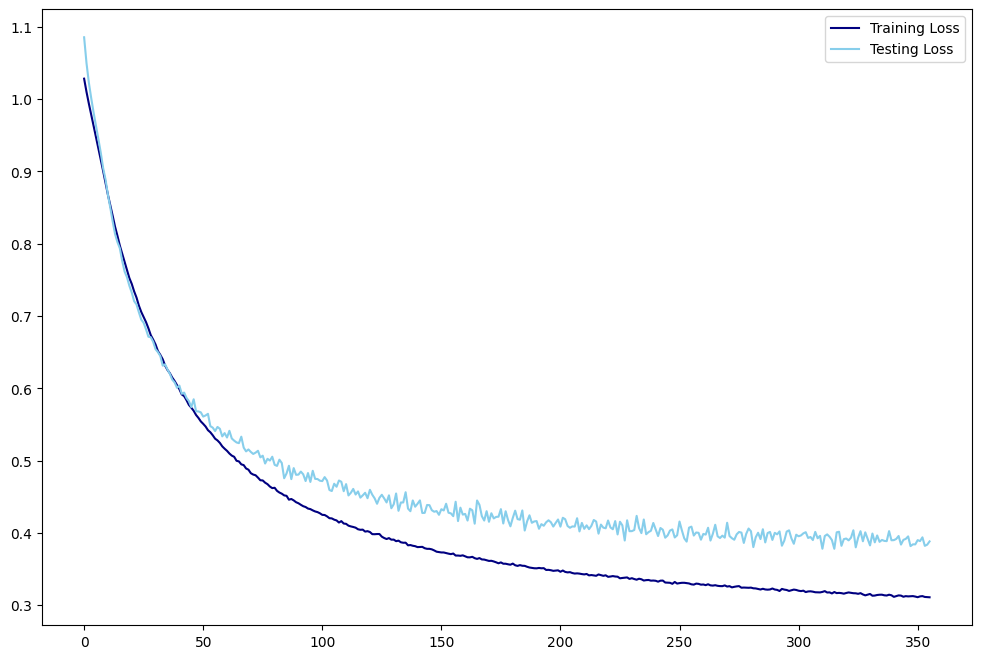

In [15]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(test_loss, label='Testing Loss', color='skyblue')
plt.legend();